In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import keras

import warnings
import seaborn as sns
import cv2
import math

from PIL import Image
from tqdm import tqdm

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pwd

/content


In [3]:
%cd ./drive/MyDrive/DL_Project/train
!ls

/content/drive/MyDrive/DL_Project/train
Cityscapes_segmentation.h5  labels.py	 semantic_segmentation_256.h5  unet.py
dataset.ipynb		    __pycache__  train.ipynb


In [4]:
warnings.filterwarnings("ignore") # 경고 메세지를 무시

sns.set_context("paper", font_scale=1.4)
# seaborn 라이브러리의 그래프를 논문(paper)에 적합한 크기로 설정, 폰트 크기는 1.4배

id_map = {
    0: np.array([0, 0, 0]), # unlabelled
    1: np.array([111, 74,  0]), #static
    2: np.array([ 81,  0, 81]), #ground
    3: np.array([128, 64,127]), #road
    4: np.array([244, 35,232]), #sidewalk
    5: np.array([250,170,160]), #parking
    6: np.array([230,150,140]), #rail track
    7: np.array([70, 70, 70]), #building
    8: np.array([102,102,156]), #wall
    9: np.array([190,153,153]), #fence
    10: np.array([180,165,180]), #guard rail
    11: np.array([150,100,100]), #bridge
    12: np.array([150,120, 90]), #tunnel
    13: np.array([153,153,153]), #pole
    14: np.array([250,170, 30]), #traffic light
    15: np.array([220,220,  0]), #traffic sign
    16: np.array([107,142, 35]), #vegetation
    17: np.array([152,251,152]), #terrain
    18: np.array([ 70,130,180]), #sky
    19: np.array([220, 20, 60]), #person
    20: np.array([255,  0,  0]), #rider
    21: np.array([  0,  0,142]), #car
    22: np.array([  0,  0, 70]), #truck
    23: np.array([  0, 60,100]), #bus
    24: np.array([  0,  0, 90]), #caravan
    25: np.array([  0,  0,110]), #trailer
    26: np.array([  0, 80,100]), #train
    27: np.array([  0,  0,230]), #motorcycle
    28: np.array([119, 11, 32]), #bicycle
}

# 매칭된 id(즉, 31가지 객체)를 8개의 카테고리로 분류
# 저사양 환경에서 간단하게 분류하고자 할 때 사용
# 일단 사용 안했음
category_map = {
    0: 0,
    1: 0,
    2: 0,
    3: 1,
    4: 1,
    5: 1,
    6: 1,
    7: 2,
    8: 2,
    9: 2,
    10: 2,
    11: 2,
    12: 2,
    13: 3,
    14: 3,
    15: 3,
    16: 4,
    17: 4,
    18: 5,
    19: 6,
    20: 6,
    21: 7,
    22: 7,
    23: 7,
    24: 7,
    25: 7,
    26: 7,
    27: 7,
    28: 7,
}

num_classes = len(id_map.keys())

print(num_classes)

29


In [6]:
import concurrent.futures
import re

row = 128
col = 128

# 이미지 리사이즈
def img_preprocess(path):
    origin_img = cv2.imread(path)
    rgb_image = cv2.cvtColor(origin_img, cv2.COLOR_BGR2RGB)
    rgb_image = cv2.resize(rgb_image, (row, col), interpolation=cv2.INTER_NEAREST)
    return rgb_image

def parallel_image_loading(path, file_list):
    images = []
    for file in tqdm(file_list, desc="Loading images"):
        img_path = os.path.join(path, file)  # 파일 경로 생성
        img = img_preprocess(img_path)
        images.append(img)
    return images

# train data(img), ground truth(mask img) 경로 입력
train_data_dir = '../data/dataset/train/leftImg'
train_label_dir = '../data/dataset/train/labelIds'

# validation data(img), ground truth(mask img) 경로 입력
val_data_dir = '../data/dataset/val/leftImg'
val_label_dir = '../data/dataset/val/labelIds'


# train data 이름으로 정렬
train_data = sorted(os.listdir(train_data_dir))
train_label = sorted(os.listdir(train_label_dir))

# validation data 이름으로 정렬
val_data = sorted(os.listdir(val_data_dir))
val_label = sorted(os.listdir(val_label_dir))

X_train = parallel_image_loading(train_data_dir, train_data)
Y_train = parallel_image_loading(train_label_dir, train_label)
X_valid = parallel_image_loading(val_data_dir, val_data)
Y_valid = parallel_image_loading(val_label_dir, val_label)

Loading images: 100%|██████████| 500/500 [00:01<00:00, 406.60it/s]


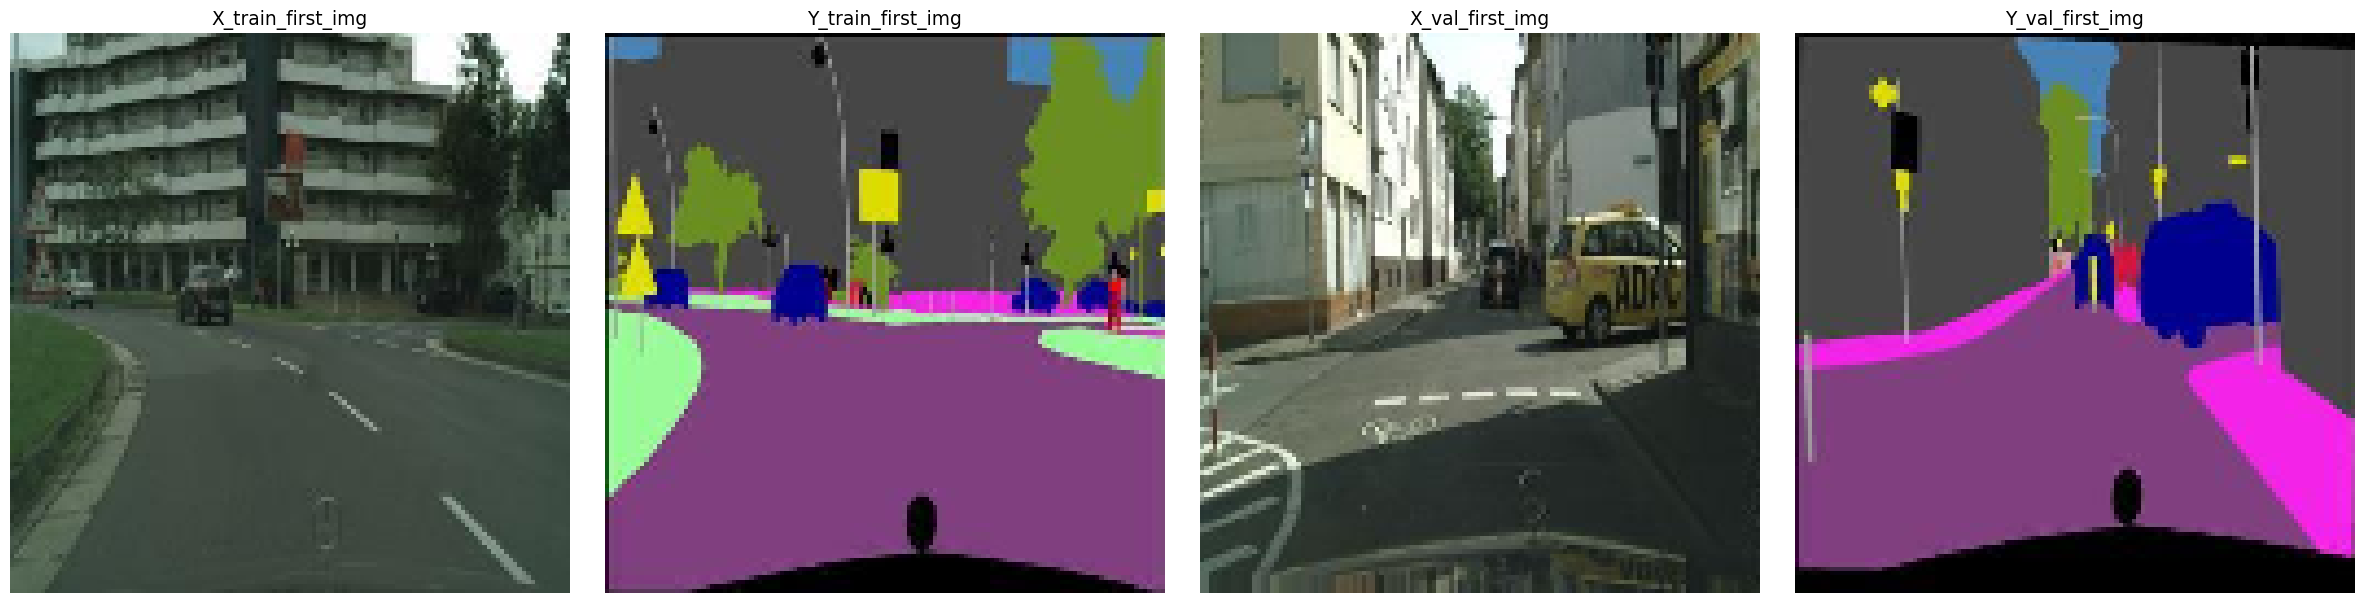

In [7]:
# 그리드 크기 설정
grid_size = (1, 4)

# 그리드 생성 및 이미지 표시
fig, axes = plt.subplots(*grid_size, figsize=(24, 6))

# X_train 이미지 표시
axes[0].imshow(X_train[0])
axes[0].axis('off')
axes[0].set_title('X_train_first_img')

# Y_train 이미지 표시
axes[1].imshow(Y_train[0])
axes[1].axis('off')
axes[1].set_title('Y_train_first_img')

# X_val 이미지 표시
axes[2].imshow(X_valid[0])
axes[2].axis('off')
axes[2].set_title('X_val_first_img')

# Y_val 이미지 표시
axes[3].imshow(Y_valid[0])
axes[3].axis('off')
axes[3].set_title('Y_val_first_img')

plt.tight_layout()
plt.show()

In [8]:
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_valid = np.array(X_valid)
Y_valid = np.array(Y_valid)

print(X_train.shape)
print(Y_train.shape)
print(X_valid.shape)
print(Y_valid.shape)

(2975, 128, 128, 3)
(2975, 128, 128, 3)
(500, 128, 128, 3)
(500, 128, 128, 3)


In [9]:
# 현 픽셀의 색상값과 가장 가까운 색상 라벨 인덱스를 리턴
def color_euclidian_dist(pixel):
    min_dist = 10000
    min_idx = 0
    for key, value in id_map.items():
        dist = (pixel[0] - value[0])**2 + (pixel[1] - value[1])**2 + (pixel[2] - value[2])**2
        if(dist <= min_dist):
            min_dist = dist
            min_idx = int(key)
    return min_idx

# 마스크 계산 함수
def calculate_mask(img):
    mask = np.zeros(shape=(img.shape[0], img.shape[1], 1), dtype=np.uint8)
    for r in range(row):
        for c in range(col):
            mask[r, c] = color_euclidian_dist(img[r, c])
    return mask

# 마스킹 함수
def mask_process(files):
    images = []
    for file in tqdm(files, desc="Masking label images"):
        img = calculate_mask(file)
        images.append(img)
    return images


# y(ground truth) 이미지들을 29개 클래스로 마스킹 작업 수행
# 마지막 채널 깊이가 1(0 ~ 29 가능)로 변함
# (n, row, col, 3) -> (n, row, col, 1)
Y_train_mask = mask_process(Y_train)
Y_valid_mask = mask_process(Y_valid)

Masking label images: 100%|██████████| 500/500 [06:29<00:00,  1.28it/s]


In [10]:
Y_train_mask = np.array(Y_train_mask)
Y_valid_mask = np.array(Y_valid_mask)

print(Y_train_mask.shape)
print(Y_valid_mask.shape)

(2975, 128, 128, 1)
(500, 128, 128, 1)


In [12]:
from unet import UNet
from tqdm import tqdm
from keras.losses import CategoricalCrossentropy
from keras.losses import SparseCategoricalCrossentropy
from keras.optimizers import Adam
from keras.metrics import MeanIoU
from keras.callbacks import ModelCheckpoint

img_size = (row, col)
model = UNet(img_size, num_classes)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 64, 64, 64)           0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [13]:
from keras.utils import to_categorical

# 256x256은 21.1GiB array를 담을 memory space가 필요해서 안됌
# 4번째 dim 깊이가 1인 y 마스크 자료형을 one_hot encoding
# (n, row, col, 1) -> (n, row, col, 29)
Y_train_mask_one_hot = to_categorical(Y_train_mask, num_classes=num_classes)
Y_valid_mask_one_hot = to_categorical(Y_valid_mask, num_classes=num_classes)

# 모델 선언
model.compile(optimizer=Adam(learning_rate = 0.0001),
              loss=CategoricalCrossentropy(),
              metrics=[MeanIoU(num_classes=num_classes)])
callbacks = [ModelCheckpoint('../saved_model/semantic_segmentation_128.h5', save_best_only=True)]

In [14]:
print(Y_train_mask.shape)
print(Y_train_mask_one_hot.shape)
print(Y_valid_mask.shape)
print(Y_valid_mask_one_hot.shape)

(2975, 128, 128, 1)
(2975, 128, 128, 29)
(500, 128, 128, 1)
(500, 128, 128, 29)


In [15]:
history = model.fit(x=X_train, y=Y_train_mask_one_hot, epochs=50, batch_size=16, validation_data=(X_valid, Y_valid_mask_one_hot), callbacks=callbacks)

Epoch 1/50
186/186 [==============================] - ETA: 0s - loss: 15.9209 - mean_io_u: 0.4839

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


186/186 [==============================] - 42s 159ms/step - loss: 15.9209 - mean_io_u: 0.4839 - val_loss: 2.2210 - val_mean_io_u: 0.4828
Epoch 2/50
186/186 [==============================] - 25s 133ms/step - loss: 2.1190 - mean_io_u: 0.4829 - val_loss: 1.8551 - val_mean_io_u: 0.4828
Epoch 3/50
186/186 [==============================] - 24s 130ms/step - loss: 1.7168 - mean_io_u: 0.4828 - val_loss: 1.5400 - val_mean_io_u: 0.4828
Epoch 4/50
186/186 [==============================] - 24s 129ms/step - loss: 1.4049 - mean_io_u: 0.4828 - val_loss: 1.3739 - val_mean_io_u: 0.4828
Epoch 5/50
186/186 [==============================] - 23s 126ms/step - loss: 1.2331 - mean_io_u: 0.4828 - val_loss: 1.2066 - val_mean_io_u: 0.4828
Epoch 6/50
186/186 [==============================] - 24s 129ms/step - loss: 1.1323 - mean_io_u: 0.4830 - val_loss: 1.1345 - val_mean_io_u: 0.4832
Epoch 7/50
186/186 [==============================] - 24s 127ms/step - loss: 1.0570 - mean_io_u: 0.4831 - val_loss: 1.0388 - val

In [17]:
from keras.models import load_model

# 저장된 모델 불러오기
loaded_model = load_model('../saved_model/semantic_segmentation_128.h5')

1/1 [==============================] - 1s 820ms/step


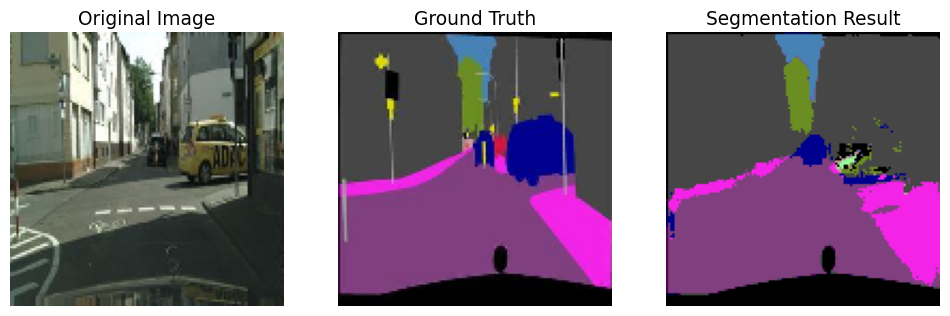

1/1 [==============================] - 0s 23ms/step


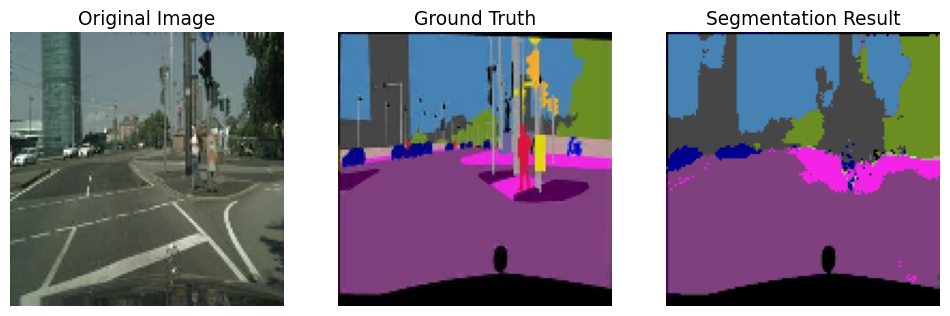

1/1 [==============================] - 0s 23ms/step


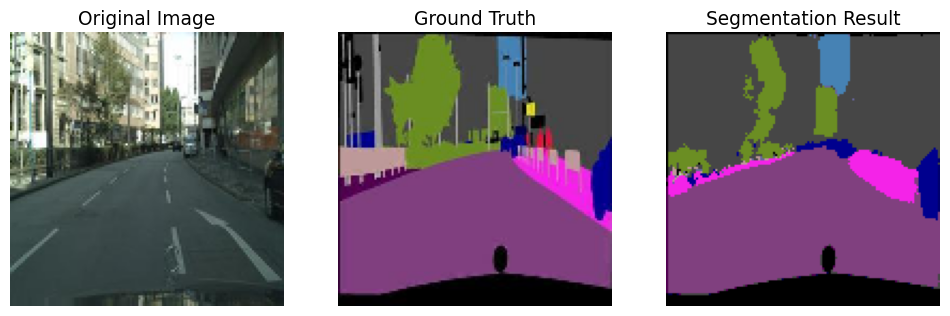

1/1 [==============================] - 0s 22ms/step


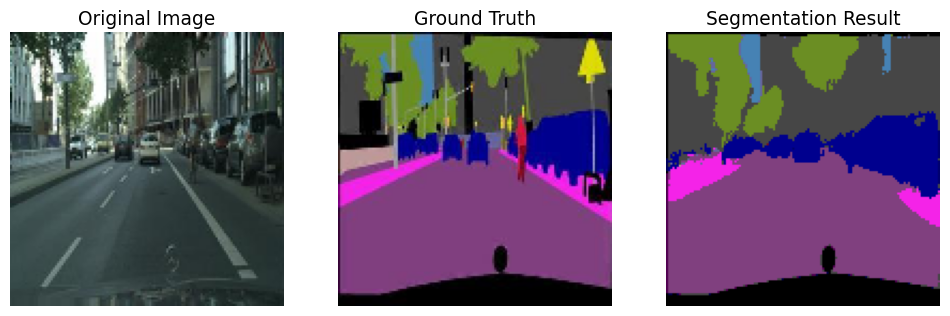

1/1 [==============================] - 0s 23ms/step


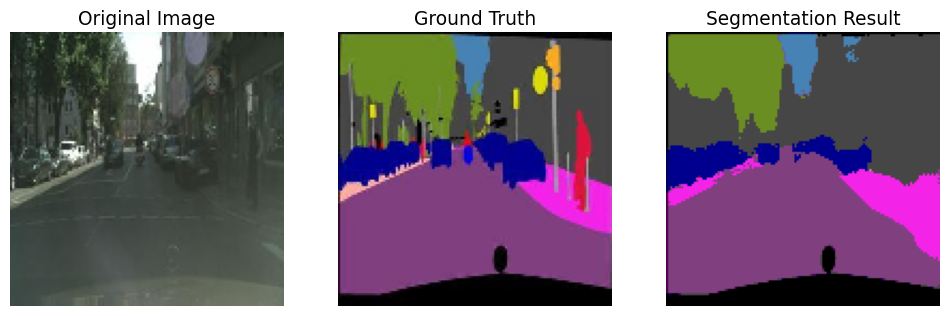

In [18]:
def prediction_plot(test_idx):
    # 검증 데이터 중 맨 첫 번째 이미지 선택
    input_image = X_valid[test_idx]
    gt_image = Y_valid[test_idx]

    # 모델을 사용하여 예측 수행
    predictions = loaded_model.predict(np.expand_dims(input_image, axis=0))

    # 매핑된 RGB 색상으로 이루어진 이미지 생성
    mapped_image = np.zeros((row, col, 3), dtype=np.uint8)

    for r in range(row):
        for c in range(col):
            label = np.argmax(predictions[0][r, c])  # 가장 높은 확률 값을 가진 라벨 선택
            mapped_image[r, c] = id_map[label]     # id_map을 사용하여 RGB 색상으로 매핑

    # 원본 이미지와 예측 결과를 시각화
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(input_image)
    plt.title('Original Image')
    plt.axis('off')

    # Y_val 이미지 표시
    plt.subplot(1, 3, 2)
    plt.imshow(gt_image)
    plt.title('Ground Truth')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(mapped_image)
    plt.title('Segmentation Result')
    plt.axis('off')

    plt.show()

prediction_plot(0)
prediction_plot(100)
prediction_plot(200)
prediction_plot(300)
prediction_plot(400)

In [22]:
import cv2

row = 128
col = 128

# 동영상 파일 경로
video_path = '../data/euro_truck/sample1_128.mp4'
# video_path = 'C:/Users/daida/Desktop/DL_Project/data/euro_truck/sample1.mp4'

# 동영상 파일 열기
cap = cv2.VideoCapture(video_path)

# 출력 동영상 파일 경로 및 설정
output_path = '../data/euro_truck/sample1_128_segmented.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, 30.0, (col, row))  # 30.0은 프레임 속도입니다.

# Semantic Segmentation 모델 로드 (예: loaded_model)
loaded_model = load_model('../saved_model/semantic_segmentation_128.h5')

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # # 프레임 크기 조정 (row, col)로
    # frame = cv2.resize(frame, (col, row))

    # 모델에 입력으로 사용할 수 있도록 전처리
    input_frame = frame / 255.0  # 입력 프레임을 0에서 1 범위로 정규화
    input_frame = np.expand_dims(input_frame, axis=0)  # 모델은 배치 크기를 기대하므로 차원 추가

    # 모델에 프레임 적용 및 예측
    predictions = loaded_model.predict(input_frame)
    predicted_mask = np.argmax(predictions[0], axis=-1)

    # 예측된 마스크를 RGB 이미지로 매핑
    segmented_frame = np.zeros((row, col, 3), dtype=np.uint8)
    for r in range(row):
        for c in range(col):
            label = predicted_mask[r, c]
            segmented_frame[r, c] = id_map[label]

    # 출력 동영상에 프레임 추가
    out.write(segmented_frame)

# 동영상 파일 닫기
cap.release()
out.release()

# 창 닫기
cv2.destroyAllWindows()

1/1 [==============================] - 0s 21ms/step


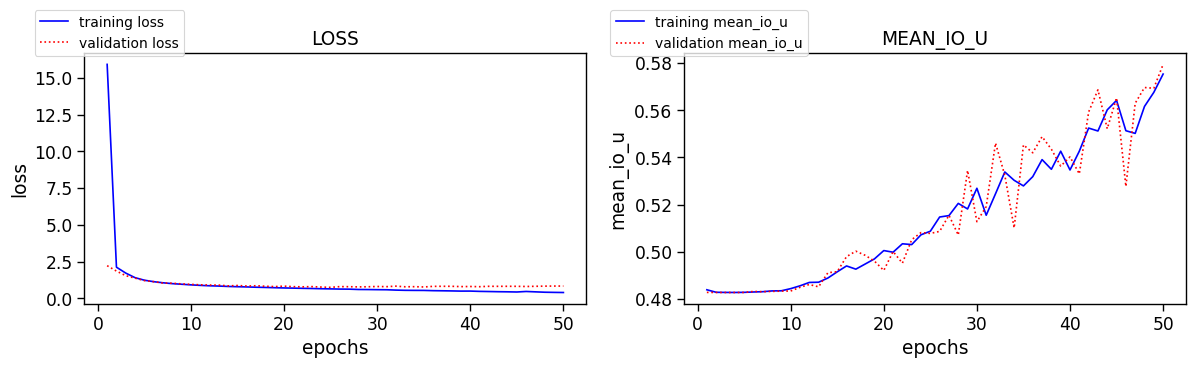

In [16]:
# 학습, 검증 정확도 출력

# 결과 시각화 함수
def vis(history,name) :
    plt.title(f"{name.upper()}")
    plt.xlabel('epochs')
    plt.ylabel(f"{name.lower()}")
    value = history.history.get(name)
    val_value = history.history.get(f"val_{name}",None)
    epochs = range(1, len(value)+1)
    plt.plot(epochs, value, 'b-', label=f'training {name}')
    if val_value is not None :
        plt.plot(epochs, val_value, 'r:', label=f'validation {name}')
    plt.legend(loc='upper center', bbox_to_anchor=(0.05, 1.2) , fontsize=10 , ncol=1)

# 결과 출력
def plot_history(history) :
    key_value = list(set([i.split("val_")[-1] for i in list(history.history.keys())]))
    plt.figure(figsize=(12, 4))
    for idx , key in enumerate(key_value) :
        plt.subplot(1, len(key_value), idx+1)
        vis(history, key)
    plt.tight_layout()
    plt.show()

plot_history(history)